<a href="https://colab.research.google.com/github/LuccaRomagnolli/Machine-Learning/blob/main/Binnary-Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pavement Condition Monitoring and Maintenance Prediction
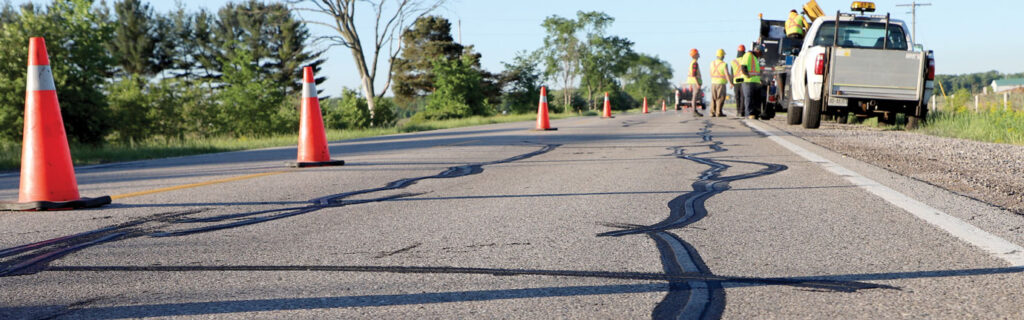

### **Scenario**

You are a data analyst for a city engineering office tasked with identifying which road segments require urgent maintenance.  
The office has collected inspection data on various roads, including surface conditions, traffic volume, and environmental factors.

Your goal is to analyze this data and build a **binary classification model** to predict whether a given road segment needs maintenance, based on pavement and environmental indicators.

### **Target Variable:** `Needs_Maintenance`

This binary label indicates whether the road segment requires immediate maintenance, defined by the following rule:

---

Needs_Maintenance = 1 → Urgent maintenance required

Needs_Maintenance = 0 → No immediate maintenance needed


---

### **Project Objectives**

  - Perform exploratory data analysis (EDA) on civil engineering infrastructure data
  - Engineer features relevant to road quality and maintenance;
  - Build and evaluate a binary classification model using Python;
  - Interpret model results to support maintenance prioritization decisions.

---
#### Author:
Lucca Maximus Romagnolli Soares (IFB - DF)

#### Professor:
 Gilberto de Melo Junior





### **Libraries** 🔨

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, fbeta_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro, levene
from statsmodels.formula.api import logit
import seaborn as sns
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings

### **Dataset** 📄

##### Data dictionary

| **Column Name**       | **Description** |
|------------------------|-----------------|
| **Segment ID**         | Unique identifier for the road segment |
| **PCI**                | Pavement Condition Index (0 = worst, 100 = best) |
| **Road Type**          | Type of road (Primary, Secondary, Barangay) |
| **AADT**               | Average Annual Daily Traffic |
| **Asphalt Type**       | Asphalt mix classification (e.g. Dense, Open-graded, SMA) |
| **Last Maintenance**   | Year of the last major maintenance |
| **Average Rainfall**   | Average annual rainfall in the area (mm) |
| **Rutting**            | Depth of rutting (mm) |
| **IRI**                | International Roughness Index (m/km) |
| **Needs Maintenance**  | Target label: 1 if urgent maintenance is needed, 0 otherwise |


In [ ]:
# Load dataset

!pip install gdown
!gdown --id 1zZdCJWer4N2zSdga_LC64DowNZ8FqUlq -O  Dataset.csv

df = pd.read_csv("Dataset.csv")
df.head()

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zZdCJWer4N2zSdga_LC64DowNZ8FqUlq
To: /content/Dataset.csv
100% 67.6M/67.6M [00:00<00:00, 77.9MB/s]


,Segment ID,PCI,Road Type,AADT,Asphalt Type,Last Maintenance,Average Rainfall,Rutting,IRI,Needs Maintenance
0,SID 155440,70.00,Secondary,4634,Concrete,2022,42.07,15.11,0.68,0
1,SID 244365,37.87,Tertiary,3474,Asphalt,2017,79.60,19.67,0.99,1
2,SID 137867,88.32,Tertiary,1734,Concrete,2019,62.69,14.73,0.50,0
3,SID 540519,52.30,Tertiary,3119,Asphalt,2008,79.32,17.01,1.04,1
4,SID 745776,49.10,Tertiary,3505,Asphalt,2019,71.81,21.08,1.18,1


##### **Feature Importance**

In [ ]:
# Reload the dataset to start from a point before scaling and splitting
df_initial = pd.read_csv("Dataset.csv")

# Drop Segment ID as it's just an identifier
df_initial = df_initial.drop(columns=["Segment ID"])

# Encode Categorical Data
categorical_cols = ["Road Type", "Asphalt Type"]
for col in categorical_cols:
    le = LabelEncoder()
    df_initial[col] = le.fit_transform(df_initial[col])

# Separate Features and Target
X_initial = df_initial.drop(columns=["Needs Maintenance"])
y_initial = df_initial["Needs Maintenance"]

# Drop rows where the target variable 'Needs Maintenance' is NaN
# This is necessary because DecisionTreeClassifier cannot handle NaN in the target
nan_rows = y_initial.isna()
X_initial = X_initial[~nan_rows]
y_initial = y_initial[~nan_rows]


# Use a simple Decision Tree model to get feature importance
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_initial, y_initial)

# Get feature importance
feature_importance_dt = pd.DataFrame({
    'Feature': X_initial.columns,
    'Importance': dt_model.feature_importances_
})

# Sort by importance
feature_importance_dt = feature_importance_dt.sort_values(by='Importance', ascending=False)

print("\nInitial Feature Importance (Decision Tree):")
display(feature_importance_dt)


Initial Feature Importance (Decision Tree):


,Feature,Importance
6,Rutting,0.942279
0,PCI,0.038148
4,Last Maintenance,0.010772
5,Average Rainfall,0.005204
3,Asphalt Type,0.003279
2,AADT,0.000130
1,Road Type,0.000106
7,IRI,0.000082


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050000 entries, 0 to 1049999
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Segment ID         1050000 non-null  object 
 1   PCI                1050000 non-null  float64
 2   Road Type          1050000 non-null  object 
 3   AADT               1050000 non-null  int64  
 4   Asphalt Type       1050000 non-null  object 
 5   Last Maintenance   1050000 non-null  int64  
 6   Average Rainfall   1050000 non-null  float64
 7   Rutting            1050000 non-null  float64
 8   IRI                1050000 non-null  float64
 9   Needs Maintenance  1050000 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 80.1+ MB


### **Preprocessing** ⛏

In [ ]:
# Drop Segment ID
df = df.drop(columns=["Segment ID"])

# Encode Categorical Data
categorical_cols = ["Road Type", "Asphalt Type"]
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Separate Features and Target
X = df.drop(columns=["Needs Maintenance"])
y = df["Needs Maintenance"]

# Transform Features (StandardScaler)
scaler = StandardScaler()
X_scaled_np = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_np, columns=X.columns, index=X.index)

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# Reset index
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### **Estatistics** ➕

    1. The observations must be independent.
    2. There must be no perfect multicollinearity among independent variables.
    3. Continuous predictors are linearly related to a transformed version of the outcome (linearity).


Reference: *Harris JK. Primer on binary logistic regression. Fam Med Community Health. 2021 Dec;9(Suppl 1):e001290. doi: 10.1136/fmch-2021-001290. PMID: 34952854; PMCID: PMC8710907.*

In [ ]:
# Using VIF to check multicollinearity among independent variables

# Drop rows with NaN values before calculating VIF
X_vif = sm.add_constant(X_scaled.dropna())
vif_df = pd.DataFrame()
vif_df["Variable"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_df)

# Using Box-Tidwell for checking linearity of all independent variables with the target

# Combine X_train and y_train for the Box-Tidwell test
train_df = pd.concat([X_train, y_train], axis=1).dropna()

# Rename columns to be valid Python identifiers
train_df.columns = [col.strip().replace(" ", "_").replace("-", "_") for col in train_df.columns]

target = 'Needs_Maintenance'
# Exclude non-numeric columns from predictors
predictors = [col for col in train_df.columns if col not in [target, 'Road_Type', 'Asphalt_Type']]

# Create log interaction terms
for var in predictors:
    train_df[f'{var}_log'] = train_df[var] * np.log(np.abs(train_df[var])) # Use np.abs to handle negative scaled values

formula = f"{target} ~ " + " + ".join(predictors + [f"{var}_log" for var in predictors])

model = logit(formula, data=train_df).fit()

print(model.summary())

           Variable       VIF
0             const  1.000000
1               PCI  2.857543
2         Road Type  2.649747
3              AADT  2.612362
4      Asphalt Type  2.242808
5  Last Maintenance  2.038936
6  Average Rainfall  3.129959
7           Rutting  4.342786
8               IRI  1.344219
Optimization terminated successfully.
         Current function value: 0.003293
         Iterations 15
                           Logit Regression Results                           
Dep. Variable:      Needs_Maintenance   No. Observations:               735000
Model:                          Logit   Df Residuals:                   734987
Method:                           MLE   Df Model:                           12
Date:                Thu, 30 Oct 2025   Pseudo R-squ.:                  0.9952
Time:                        13:34:19   Log-Likelihood:                -2420.0
converged:                       True   LL-Null:                   -5.0946e+05
Covariance Type:            nonrobust   LLR 

#### Explanation for non-technical people ♨

#### Strong Positive Indicators (Increase Maintenance Risk) ⭕
- **Rutting** (road surface grooves) - *Most significant factor*
- **IRI** (road roughness/bumpiness)
- **AADT_log** (long-term traffic patterns)

#### Strong Negative Indicators (Decrease Maintenance Risk) 🟢
- **PCI** (Pavement Condition Index) - Better condition = less maintenance
- **AADT** (current traffic volume)

#### Not Significant
- **Average Rainfall** - No strong relationship found



---


### Warning ⚠️

**Possible Data Issue Detected:**
- 91% of cases can be perfectly predicted
- This suggests "quasi-separation" - data may be too clear-cut
- Could indicate:
  - Roads are either very good or very bad (few moderate cases)
  - Overlapping measurements
  - Need for model validation


---


#### Recommendation
Validate results with field experts before implementation, as the extremely high
accuracy may indicate data limitations rather than true predictive power.

### **Linearity Analzyis** 📈

#### Linearity Analysis - Logistic Regression for Pavement Maintenance

**Objective**

To verify whether pavement condition indicators (PCI and IRI) have a **linear relationship**
with the probability of maintenance needs, a fundamental assumption of logistic regression.
| **Variable**       | **Description** |
|------------------------|-----------------|
| **PCI**                | Pavement Condition Index (0 = worst, 100 = best) |
| **IRI**                | International Roughness Index (m/km) |

**Methodology**

  1. **Data:** Dataset with pavement condition indices and maintenance status
  2. **Model:** `Logistic regression` using PCI (quality) and IRI (roughness) as predictors
  3. **Validation:** Plotting the logit (log-odds) versus each predictor to verify linearity

Optimization terminated successfully.
         Current function value: 0.122213
         Iterations 9


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


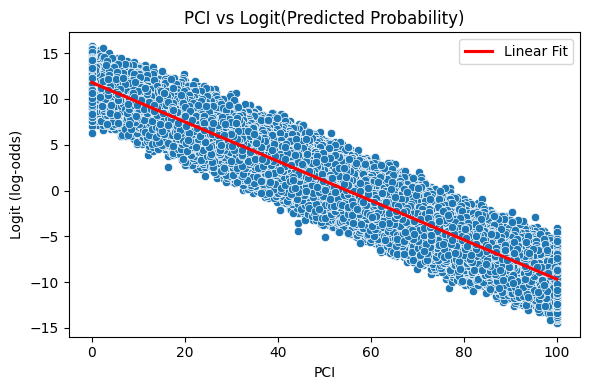

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


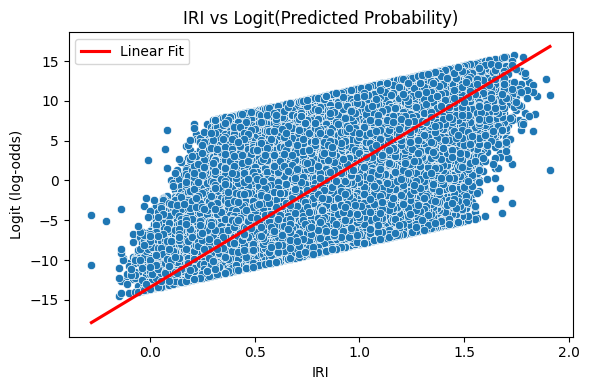

In [ ]:
# Load dataset
df = pd.read_csv("Dataset.csv")

# Clean column names (remove leading/trailing spaces and replace spaces with underscores)
df.columns = df.columns.str.strip().str.replace(" ", "_")

# Select relevant columns and drop rows with NaN values
df = df[['PCI', 'IRI', 'Needs_Maintenance']].dropna()

# Define independent variables (X) and dependent variable (y)
X = df[['PCI', 'IRI']]
y = df['Needs_Maintenance']

# Add a constant to the independent variables for statsmodels
X_const = sm.add_constant(X)

# Fit logistic regression model using statsmodels
model = sm.Logit(y, X_const)
result = model.fit()

# Predict probabilities using the fitted model
df['predicted_prob'] = result.predict(X_const)

# Calculate the logit (log-odds) of the predicted probabilities
df['logit'] = np.log(df['predicted_prob'] / (1 - df['predicted_prob']))

# Plot logit against each predictor to check for linearity
for predictor in ['PCI', 'IRI']:
    plt.figure(figsize=(6, 4))
    # Create a scatter plot of the predictor vs the logit
    sns.scatterplot(x=df[predictor], y=df['logit'])
    # Add a linear regression line to the scatter plot (without displaying scatter points)
    sns.regplot(x=df[predictor], y=df['logit'], scatter=False, color='red', label='Linear Fit')

    plt.title(f'{predictor} vs Logit(Predicted Probability)')
    plt.xlabel(predictor)
    plt.ylabel('Logit (log-odds)')
    plt.legend()
    plt.tight_layout()
    plt.show()



> #### **Conclusion**

The graphs validate the **linearity of the logit assumption**, confirming that:
- PCI and IRI are appropriate predictors for logistic regression
- The model can reliably estimate the probability of maintenance
- The observed relationships are consistent with theory: degraded and
  irregular pavements require more maintenance

### **Base Model (Logit)**

In [ ]:
# Rename columns to remove spaces
df.columns = df.columns.str.strip().str.replace(" ", "_")

# Select features and target
features = ['PCI', 'IRI']
target = 'Needs_Maintenance'

# Drop rows with NaN values (if any)
df = df[features + [target]].dropna()

X = df[features]
y = df[target].astype(int)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression Model
model = LogisticRegression(max_iter=1000,random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#### Evaluation

`Accuracy`

Proportion of correctly classified road segments (both needing and not needing maintenance).
A higher value means the model predicts maintenance needs correctly more often.

`Precision`

Proportion of correctly identified maintenance needs among all predicted as needing maintenance.
Higher precision means fewer false alarms.

`F2 Score`

Weighted harmonic mean of precision and recall, giving more importance to recall.
Emphasizes finding all segments that truly need maintenance while minimizing missed cases.

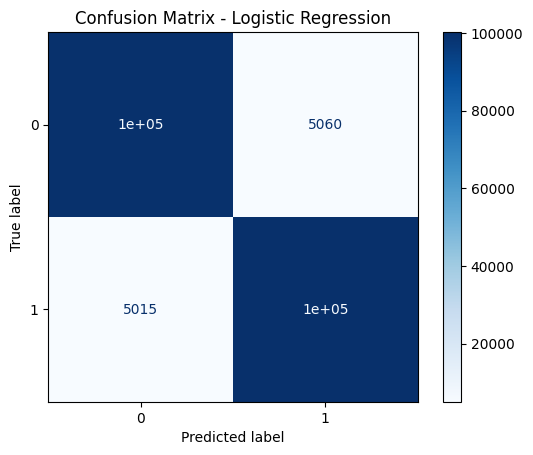

True Negatives (TN): 99679
False Positives (FP): 5060
False Negatives (FN): 5015
True Positives (TP): 100246

Model Evaluation Table:
   Metric    Value
 Accuracy 0.952024
Precision 0.951950
 F2 Score 0.952275


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2)

# Evaluation Table
eval_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "F2 Score"],
    "Value": [accuracy, precision, f2]
})


tn, fp, fn, tp = cm.ravel()

print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")
print("\nModel Evaluation Table:")
print(eval_df.to_string(index=False))

### **Experimentation 🧪**

#### **Another models vs Logistic Regression**

In [ ]:

# Define a dictionary of models to compare
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Neural Network": MLPClassifier(random_state=42, max_iter=1000)
}

# Dictionary to store evaluation results
results = {}

# Iterate over models, train, predict, and evaluate
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)

    # Store results
    results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC-ROC": auc_roc
    }
    print(f"{model_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC-ROC: {auc_roc:.4f}")

# Create a DataFrame from the results
results_df = pd.DataFrame(results).T

# Print the comparison table
print("\nModel Comparison Table:")
print(results_df.to_string())

Training Logistic Regression...
Logistic Regression - Accuracy: 0.9520, Precision: 0.9519, Recall: 0.9524, F1 Score: 0.9522, AUC-ROC: 0.9908
Training Decision Tree...
Decision Tree - Accuracy: 0.9306, Precision: 0.9387, Recall: 0.9217, F1 Score: 0.9301, AUC-ROC: 0.9405
Training Random Forest...
Random Forest - Accuracy: 0.9352, Precision: 0.9354, Recall: 0.9354, F1 Score: 0.9354, AUC-ROC: 0.9800
Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.9518, Precision: 0.9515, Recall: 0.9525, F1 Score: 0.9520, AUC-ROC: 0.9907
Training K-Nearest Neighbors...
K-Nearest Neighbors - Accuracy: 0.9465, Precision: 0.9467, Recall: 0.9467, F1 Score: 0.9467, AUC-ROC: 0.9774
Training Neural Network...
Neural Network - Accuracy: 0.9519, Precision: 0.9481, Recall: 0.9565, F1 Score: 0.9523, AUC-ROC: 0.9908

Model Comparison Table:
                     Accuracy  Precision    Recall  F1 Score   AUC-ROC
Logistic Regression  0.952024   0.951950  0.952357  0.952153  0.990815
Decision Tree        0.93

##### ⭕ By the results we´ll choice `Logistic Regression` Algorithm

#### **Hyperparameter tuning**

##### Hyperparameters Guide

##### Regularization Types (`penalty`)

| Type | Formula | Characteristics | Compatible Solvers |
|------|---------|-----------------|-------------------|
| **`'l1'`** | λ Σ\|wᵢ\| | Sparse models, zeros coefficients, feature selection | `'liblinear'`, `'saga'` |
| **`'l2'`** | λ Σwᵢ² | Default, gradually reduces coefficients, prevents overfitting | `'lbfgs'`, `'liblinear'`, `'sag'`, `'saga'`, `'newton-cg'` |
| **`'elasticnet'`** | λ₁Σ\|wᵢ\| + λ₂Σwᵢ² | Combines L1 and L2, handles correlated features | `'saga'` |
| **`'none'`** | - | No penalty, overfitting risk | `'lbfgs'`, `'sag'`, `'saga'`, `'newton-cg'` |


---


##### Parameter C

| C Value | Regularization Strength | Model Effect |
|---------|------------------------|--------------|
| 0.001 - 0.01 | Very strong | Very simple model |
| 0.1 - 1.0 | Moderate | Bias-variance balance |
| 10 - 100 | Weak | More complex model |
| 1000+ | Almost none | Close to no regularization |

Rule: `C = 1/λ` → Higher C = weaker regularization


---


#### Solvers

| Solver | Dataset Size | Penalties | Main Use |
|--------|-------------|-----------|----------|
| **`'lbfgs'`** | Medium/Large | `'l2'`, `'none'` | Recommended default |
| **`'liblinear'`** | Small | `'l1'`, `'l2'` | Small datasets |
| **`'saga'`** | Large | All | Only one for elasticnet |
| **`'sag'`** | Large | `'l2'`, `'none'` | Large datasets with L2 |
| **`'newton-cg'`** | Medium | `'l2'`, `'none'` | High precision |


---



##### Decision Guide

| Situation | Configuration |
|-----------|---------------|
| Baseline/initial | `penalty='l2'`, `C=1.0`, `solver='lbfgs'` |
| Feature selection | `penalty='l1'`, `C=0.1`, `solver='saga'` |
| Correlated features | `penalty='elasticnet'`, `C=1.0`, `solver='saga'` |
| Small dataset | `solver='liblinear'` |
| Large dataset | `solver='saga'` |
| Strong overfitting | `C=0.01` |
| Underfitting | `C=100` |


---


##### Important Rules

- Always normalize/standardize features first
- Start with L2 as baseline
- Use GridSearchCV to find best C
- L1 doesn't work with 'lbfgs'
- Elasticnet requires 'saga'

In [ ]:
warnings.filterwarnings('ignore')

# Option 1: Complete Grid Search (slower, but more comprehensive)
complete_param_grid = [
    {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear', 'saga']
    },
    {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1'],
        'solver': ['liblinear', 'saga']
    },
    {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['elasticnet'],
        'solver': ['saga'],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    }
]

# # Option 2: Simplified Grid Search (faster)
# simple_param_grid = {
#     'C': [0.01, 0.1, 1, 10, 100],
#     'penalty': ['l2'],
#     'solver': ['lbfgs', 'saga']
# }

# Choose which grid to use (change here)
param_grid = complete_param_grid  # Change to complete_param_grid if you want full search

# Configure GridSearchCV
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,  # Uses all available processors
    verbose=1,   # Shows progress
    return_train_score=True
)

# Train the model
print("Starting Grid Search...")
print("This process may take a few minutes depending on data size...")
grid_search.fit(X_train, y_train)
print("Grid Search completed!")

# Results
print("\n" + "="*60)
print("BEST HYPERPARAMETERS FOUND:")
print("="*60)
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest F1 Score (Cross-Validation): {grid_search.best_score_:.4f}")

# Retrieve the best model
best_model = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_model.predict(X_test)
from sklearn.metrics import f1_score, classification_report, confusion_matrix

test_f1 = f1_score(y_test, y_pred)
print(f"F1 Score on TEST set: {test_f1:.4f}")

print("\n" + "="*60)
print("CLASSIFICATION REPORT (Test):")
print("="*60)
print(classification_report(y_test, y_pred))

# Top 3 best combinations
print("\n" + "="*60)
print("TOP 3 HYPERPARAMETER COMBINATIONS:")
print("="*60)
import pandas as pd
results_df = pd.DataFrame(grid_search.cv_results_)
top_3 = results_df.nlargest(3, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
for idx, row in top_3.iterrows():
    print(f"\n{idx+1}. Params: {row['params']}")
    print(f"   F1 Score: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")

Iniciando Grid Search...
Este processo pode demorar alguns minutos dependendo do tamanho dos dados...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Grid Search concluído!

MELHORES HIPERPARÂMETROS ENCONTRADOS:
  C: 10
  penalty: l1
  solver: liblinear

Melhor F1 Score (Validação Cruzada): 0.9520
F1 Score no conjunto de TESTE: 0.9504

RELATÓRIO DE CLASSIFICAÇÃO (Teste):
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     16286
           1       0.95      0.95      0.95     16269

    accuracy                           0.95     32555
   macro avg       0.95      0.95      0.95     32555
weighted avg       0.95      0.95      0.95     32555


TOP 3 COMBINAÇÕES DE HIPERPARÂMETROS:

27. Params: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
   F1 Score: 0.9520 (+/- 0.0015)

29. Params: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
   F1 Score: 0.9520 (+/- 0.0015)

25. Params: {'C': 1, 'penalty': 'l1', 'solver': 'lib

##### Best model Upload


In [ ]:
import joblib

# Save the model
joblib.dump(best_model, 'best_logistic_model.pkl')
print("✓ Modelo salvo como 'best_logistic_model.pkl'")


# # -> Load the model
# model = joblib.load('best_logistic_model.pkl')

# # -> Use the model
# predictions = model.predict(X_new)
# probabilities = model.predict_proba(X_new)

✓ Modelo salvo como 'best_logistic_model.pkl'


### **Final Model Results** 🟢

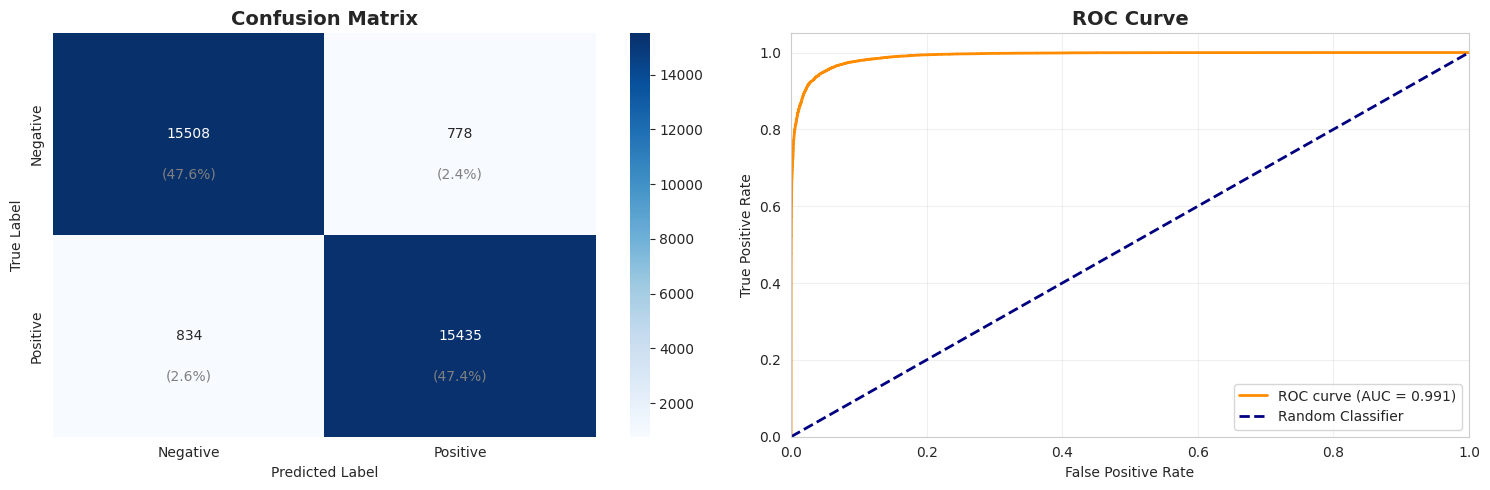

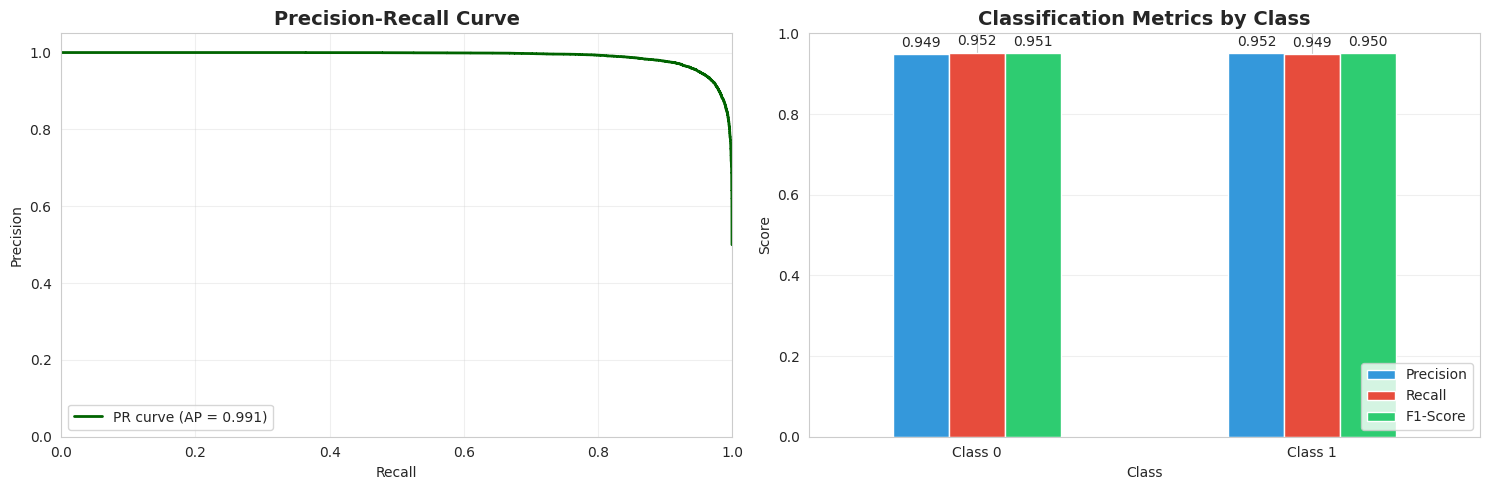

In [ ]:
# @title
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

# Set style
sns.set_style("whitegrid")

# Create predictions (run this once)
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. Confusion Matrix
ax1 = axes[0]
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'], ax=ax1)
ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# Add percentage annotations
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / cm.sum() * 100
        ax1.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)',
                ha='center', va='center', fontsize=10, color='gray')

# 2. ROC Curve
ax2 = axes[1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

ax2.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.3f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc="lower right")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 3. Precision-Recall Curve
ax3 = axes[0]
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

ax3.plot(recall, precision, color='darkgreen', lw=2,
         label=f'PR curve (AP = {avg_precision:.3f})')
ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax3.legend(loc="lower left")
ax3.grid(alpha=0.3)
ax3.set_ylim([0.0, 1.05])
ax3.set_xlim([0.0, 1.0])

# 4. Classification Metrics Bar Plot
ax4 = axes[1]
report = classification_report(y_test, y_pred, output_dict=True)
metrics_df = pd.DataFrame({
    'Precision': [report['0']['precision'], report['1']['precision']],
    'Recall': [report['0']['recall'], report['1']['recall']],
    'F1-Score': [report['0']['f1-score'], report['1']['f1-score']]
}, index=['Class 0', 'Class 1'])

metrics_df.plot(kind='bar', ax=ax4, color=['#3498db', '#e74c3c', '#2ecc71'])
ax4.set_title('Classification Metrics by Class', fontsize=14, fontweight='bold')
ax4.set_ylabel('Score')
ax4.set_xlabel('Class')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0)
ax4.set_ylim([0, 1])
ax4.legend(loc='lower right')
ax4.grid(axis='y', alpha=0.3)

# Add value labels on bars
for container in ax4.containers:
    ax4.bar_label(container, fmt='%.3f', padding=3)




plt.tight_layout()
plt.show()